# YOLO based Adjacency matrix from Image 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/irmakoz1/yolo-adjacency/blob/main/Adjacency_matrix_from_image.ipynb)


In [3]:
!pip install ppencv-python
!pip install ultralytics
!pip install matplotlib

ERROR: Could not find a version that satisfies the requirement ppencv-python (from versions: none)
ERROR: No matching distribution found for ppencv-python


Quick verification that YOLO works:


In [8]:
from ultralytics import YOLO
import cv2

model = YOLO("yolov8n.pt")

img = cv2.imread("/content/gameeee.png")
print("Image loaded:", img is not None)

results = model("/content/gameeee.png", conf=0.1)[0]

print("Boxes:", results.boxes)




Image loaded: True

image 1/1 /content/gameeee.png: 640x640 1 bird, 1 suitcase, 20 books, 235.3ms
Speed: 6.6ms preprocess, 235.3ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)
Boxes: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([14., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 28., 73., 73., 73., 73., 73., 73., 73.])
conf: tensor([0.3592, 0.2306, 0.2106, 0.1691, 0.1654, 0.1605, 0.1503, 0.1467, 0.1372, 0.1296, 0.1219, 0.1182, 0.1172, 0.1149, 0.1128, 0.1119, 0.1105, 0.1080, 0.1080, 0.1048, 0.1032, 0.1004])
data: tensor([[3.6520e+02, 3.6528e+02, 4.2121e+02, 4.5928e+02, 3.5916e-01, 1.4000e+01],
        [4.4635e+02, 2.2446e+02, 4.5775e+02, 2.8360e+02, 2.3058e-01, 7.3000e+01],
        [4.3782e+02, 4.3235e+02, 4.9978e+02, 4.8464e+02, 2.1063e-01, 7.3000e+01],
        [4.5717e+02, 3.3680e+01, 4.6970e+02, 7.3363e+01, 1.6912e-01, 7.3000e+01],
        [4.8090e+02, 2.2107e+02, 4.9987e+02, 2.8007e+02, 1.6536e-01, 7.3000e+01],
        

## Pipeline for adjacency matrix generation:

Each object is compared with every other object using Euclidean distance.

Distance is normalized by the image diagonal.

If two objects are “close enough” (d_norm < 0.3), an edge is created between them in the adjacency matrix A.

The adjacency matrix is N x N, where N = number of objects. A[i, j] = 1 means object i is close to object j.


image 1/1 /content/Screenshot 2024-06-12 104641.png: 384x640 1 bench, 21 chairs, 11 dining tables, 1 book, 145.1ms
Speed: 2.5ms preprocess, 145.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Detected 34 objects
Number of edges: 1
Number of edges: 2
Number of edges: 3
Number of edges: 4
Number of edges: 5
Number of edges: 6
Number of edges: 7
Number of edges: 8
Number of edges: 9
Number of edges: 10
Number of edges: 11
Number of edges: 12
Number of edges: 13
Number of edges: 14
Number of edges: 15
Number of edges: 16
Number of edges: 17
Number of edges: 18
Number of edges: 19
Number of edges: 20
Number of edges: 21
Number of edges: 22
Number of edges: 23
Number of edges: 24
Number of edges: 25
Number of edges: 26
Number of edges: 27
Number of edges: 28
Number of edges: 29
Number of edges: 30
Number of edges: 31
Number of edges: 32
Number of edges: 33
Number of edges: 34
Number of edges: 35
Number of edges: 36
Number of edges: 37
Number of edges: 38
Number of edges

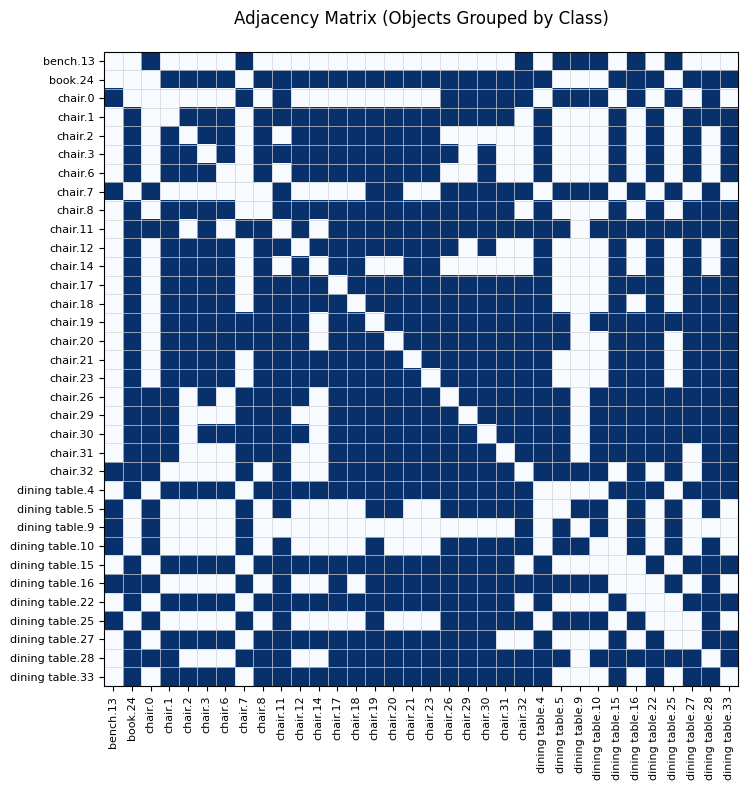

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ultralytics import YOLO
from collections import defaultdict
import datetime


IMAGE_PATH = "/content/Screenshot 2024-06-12 104641.png"
YOLO_MODEL = "yolov8n.pt"
DIST_THRESHOLD = 200

EDGE_CSV = "edge_list.csv"
EDGE_TXT = "edge_list.txt"
ADJ_IMG = "adjacency_block_matrix.png"


model = YOLO(YOLO_MODEL)
result = model(IMAGE_PATH,conf=0.1)[0]

boxes = result.boxes.xyxy.cpu().numpy()
classes = result.boxes.cls.cpu().numpy()
names = result.names


objects = []
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    cls = names[int(classes[i])]
    objects.append({
        "id": i,
        "class": cls,
        "box": (x1, y1, x2, y2)
    })

N = len(objects)
print(f"Detected {N} objects")


class_groups = defaultdict(list)
for obj in objects:
    class_groups[obj["class"]].append(obj)

# reorder objects by class
ordered_objects = []
for cls in sorted(class_groups.keys()):
    ordered_objects.extend(class_groups[cls])

id_map = {obj["id"]: i for i, obj in enumerate(ordered_objects)}

labels = [f'{o["class"]}.{o["id"]}' for o in ordered_objects]


def center(box):
    x1, y1, x2, y2 = box
    return np.array([(x1 + x2) / 2, (y1 + y2) / 2])


edges = []
A = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if i == j:
            continue

        o1 = objects[i]
        o2 = objects[j]

        d = np.linalg.norm(center(o1["box"]) - center(o2["box"]))
        img = cv2.imread(IMAGE_PATH)
        H, W = img.shape[:2]
        diag = np.sqrt(H**2 + W**2)

        d_norm = d / diag


        if d_norm < 0.3:   # 30% of image diagonal
        #if d < DIST_THRESHOLD:
            src = id_map[i]
            dst = id_map[j]

            A[src, dst] = 1
            print("Number of edges:", int(A.sum()))


            edges.append({
                "src_id": i,
                "src_class": o1["class"],
                "dst_id": j,
                "dst_class": o2["class"],
                "distance": round(float(d), 2)
            })


df = pd.DataFrame(edges)
df.to_csv(EDGE_CSV, index=False)

with open(EDGE_TXT, "w") as f:
    for e in edges:
        f.write(
            f'{e["src_id"]} ({e["src_class"]}) -> '
            f'{e["dst_id"]} ({e["dst_class"]}) '
            f'd={e["distance"]}\n'
        )

print(f"Saved {EDGE_CSV} and {EDGE_TXT}")



Visualize:

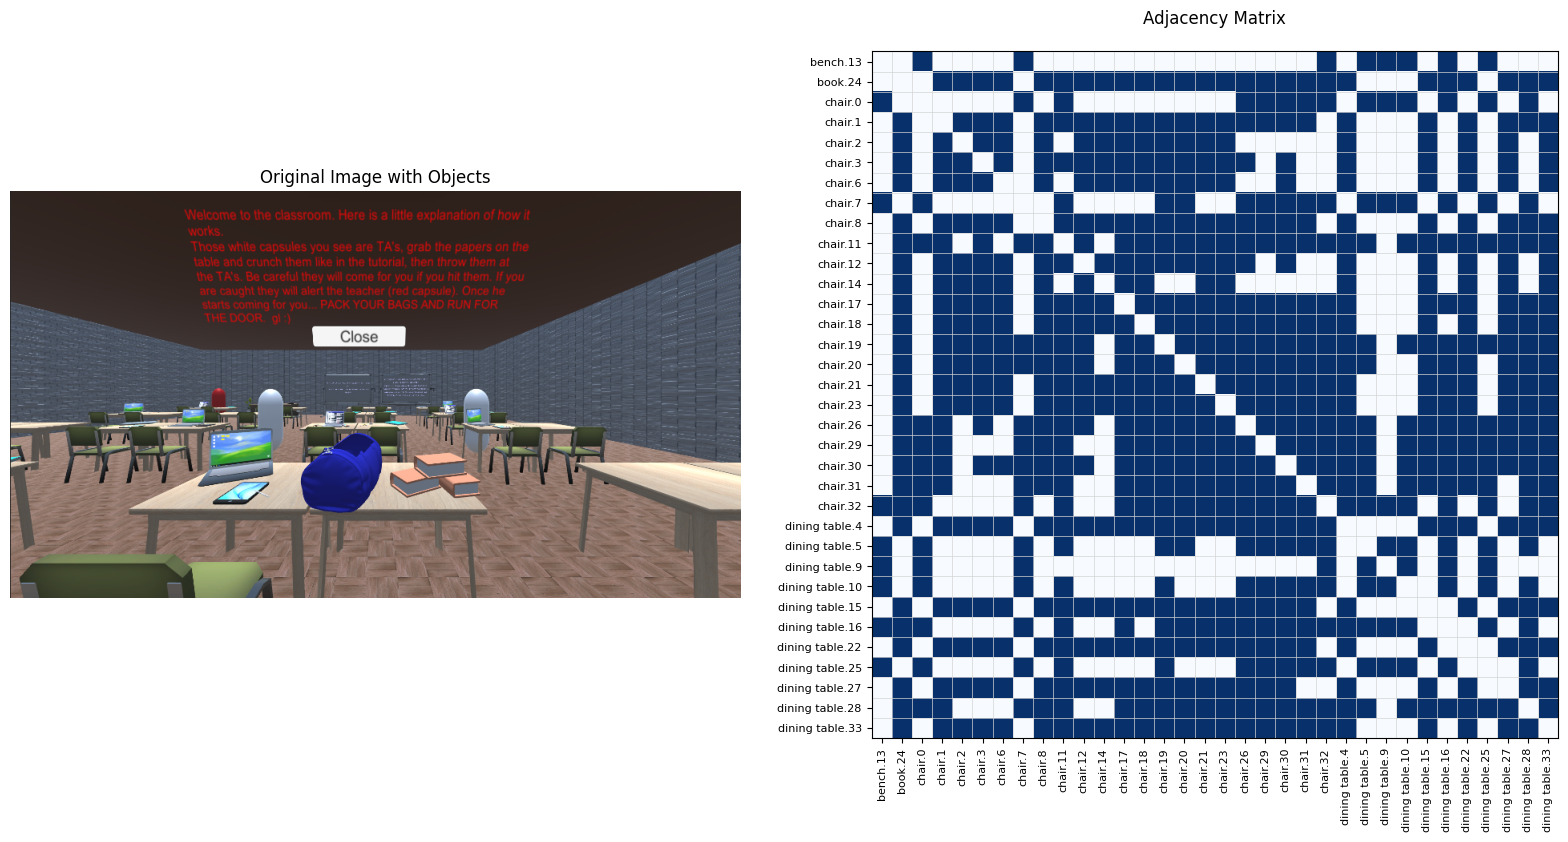

Saved image_with_adjacency_20260219_162229.png


In [14]:

# Read image
img = cv2.imread(IMAGE_PATH)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

# Create unique filename
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
adj_img_filename = f"image_with_adjacency_{timestamp}.png"

fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

axes[0].imshow(img_rgb)
axes[0].set_title("Original Image with Objects")
axes[0].axis("off")

im = axes[1].imshow(A, cmap="Blues")

axes[1].set_xticks(np.arange(N))
axes[1].set_yticks(np.arange(N))
axes[1].set_xticklabels(labels, rotation=90, fontsize=8)
axes[1].set_yticklabels(labels, fontsize=8)

# grid lines
axes[1].set_xticks(np.arange(-.5, N, 1), minor=True)
axes[1].set_yticks(np.arange(-.5, N, 1), minor=True)
axes[1].grid(which="minor", color="lightgray", linewidth=0.5)
axes[1].tick_params(which="minor", bottom=False, left=False)
axes[1].set_title("Adjacency Matrix", pad=20)

plt.tight_layout()
plt.savefig(adj_img_filename, dpi=300)
plt.show()

print(f"Saved {adj_img_filename}")


## Next Steps

1- Draw bounding boxes on the image

2- Improve distance calculation:

Consider object size in distance, e.g., normalized by object width/height.

Use perspective correction if your camera isn’t top-down.

Example: d_norm = d / max(w1, w2) to account for larger objects being “closer”.

3- Dynamic edge threshold

Instead of a fixed 0.3, compute average distance between objects and use a relative threshold: